# D(St)reams of Anomalies
  The real word does not slow down for the bad data

In [40]:
import numpy as np
import pandas as pd
import datetime
from sklearn.ensemble import IsolationForest

### Load the Data Set into Pandas
Import the csv files into Pandas Data Frame

Data retrieved from: https://www.kaggle.com/boltzmannbrain/nab

In [55]:
title = "                                  D(St)reams of Anomalies.csv"                              
print(title)
data_raw = pd.read_csv("nyc_taxi.csv")
#only shows head() to avoid the mess
data_raw.head()

                                  D(St)reams of Anomalies.csv


,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


value: Number of NYC taxi passengers

## Exploratory Data Analysis: 
### (1) NaN value Check

Let's check if there's any missing value in data set.

In [58]:
data_raw.dropna

<bound method DataFrame.dropna of                  timestamp  value
0      2014-07-01 00:00:00  10844
1      2014-07-01 00:30:00   8127
2      2014-07-01 01:00:00   6210
3      2014-07-01 01:30:00   4656
4      2014-07-01 02:00:00   3820
...                    ...    ...
10315  2015-01-31 21:30:00  24670
10316  2015-01-31 22:00:00  25721
10317  2015-01-31 22:30:00  27309
10318  2015-01-31 23:00:00  26591
10319  2015-01-31 23:30:00  26288

[10320 rows x 2 columns]>

In [59]:
data_raw.isnull().sum()

timestamp    0
value        0
dtype: int64

if it returns 0 then it means there's no missing value in data set.

### (2) re-organize the data set

Seprate timestamp into year, month, day, and time.

In [20]:
data_raw['year'] = data_raw['timestamp'].str[:4]
data_raw['month'] = data_raw['timestamp'].str[5] + data_raw['timestamp'].str[6]
data_raw['day'] = data_raw['timestamp'].str[8] + data_raw['timestamp'].str[9]
data_raw['time'] = data_raw['timestamp'].str[10:]
data = data_raw.drop(columns=['timestamp'])
#only shows head() to avoid the mess
data.head()

,value,year,month,day,time
0,10844,2014,07,01,00:00:00
1,8127,2014,07,01,00:30:00
2,6210,2014,07,01,01:00:00
3,4656,2014,07,01,01:30:00
4,3820,2014,07,01,02:00:00


After reorganizing the data set, it's pretty clear to tell that there are 10844 taxi passengers in NYC on 2014/07/01 0:00:00.

## anomaly detection models

### Interquartile Range model (IQR)
H-spread is equal to the difference between 75th and 25th percentiles. IQR = q3 - q1. However, I have to transfer the integer timestamp into DateTime timestamp to fit IQR's format by using pd.to_datetime.

In [21]:
data_raw2 = pd.read_csv("nyc_taxi.csv")
data_raw2['timestamp'] =  pd.to_datetime(data_raw2['timestamp'], format='%Y-%m-%d %H:%M:%S')
data2 = data_raw2.set_index('timestamp')
data2.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


In [22]:
print(data2.index)

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq=None)


In [23]:
q1 = data2['value'].quantile(0.25)
q3 = data2['value'].quantile(0.75)

In [61]:
a = data2['value'].between(q1, q3, inclusive=True)
IQR = data2.loc[a, 'value']

<AxesSubplot:xlabel='timestamp'>

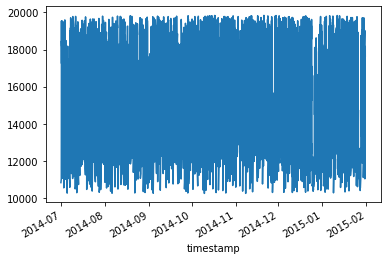

In [62]:
IQR.plot()

<AxesSubplot:xlabel='timestamp'>

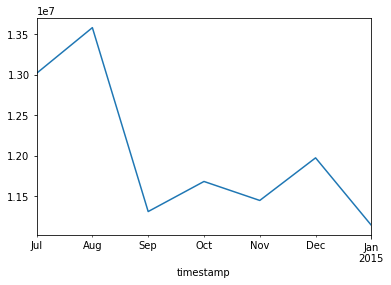

In [63]:
monthly_IQR = iqr.resample('M').sum()
monthly_IQR.plot()

<AxesSubplot:xlabel='timestamp'>

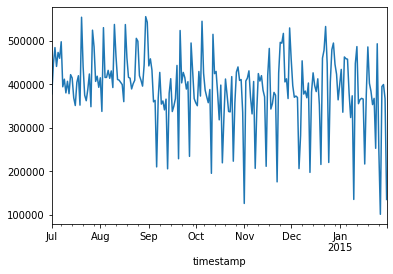

In [64]:
daily_IQR = iqr.resample('D').sum()
daily_IQR.plot()

According to kaggle, where the five anomalies occur
during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow
storm. It seems like that the graph generated by IQR does match the result from kaggle.

In [65]:
IQR.describe()

count     5160.000000
mean     16313.064147
std       2359.987115
min      10263.000000
25%      14844.500000
50%      16778.000000
75%      18151.000000
max      19838.000000
Name: value, dtype: float64

### Isolation Forest model

Limited accuracy is one of characteristics of IQR, but I hope to get exact numbers of anomalies. Then let's try Isolation Forest for a better performance on accuracy !

In [66]:
# convert x into 2-D array to be applied on Isolation Forest model 
x = data2.resample('D').sum()
X = x
model = IsolationForest(n_estimators=500, max_samples='auto', contamination=float(0.1), max_features=1.0)
model.fit(X)

IsolationForest(contamination=0.1, n_estimators=500)

In [52]:
ISFO = IsolationForest(n_estimators = 500, contamination = 0.01)
ISFO = ISFO.fit(X)
ISFO

IsolationForest(contamination=0.01, n_estimators=500)

In [54]:
ISFO_anomalies = X[iso_forest.predict(X) == -1]
print(ISFO_anomalies)

             value
timestamp         
2014-07-04  552565
2014-07-06  550285
2014-09-01  556314
2014-09-06  881714
2014-09-20  862756
2014-10-18  901390
2014-10-25  878462
2014-11-01  986568
2014-11-08  905152
2014-11-15  883958
2014-11-27  523184
2014-12-06  890958
2014-12-13  876676
2014-12-19  855719
2014-12-20  862639
2014-12-25  379302
2014-12-26  499102
2014-12-28  576228
2015-01-04  565709
2015-01-19  575177
2015-01-26  375311
2015-01-27  232058


## Conclusion 

According to kaggle and my IQR analysis above, the result seems pretty awesome to me. Isolation Forest model not only returns the several highest value from the data set but also returns the lowest value, 232058, which is also the anomale in the data set.